In [2]:
# Import
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Import data
data = pd.read_csv('01_data/data_stocks.csv')

# Drop date variable
data = data.drop(['DATE'], 1)

# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]

# Make data a np.array
data = data.values
(n, p)

(41266, 501)

In [3]:
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n-50
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [4]:
data_train

array([[2363.6101,   42.33  ,  143.68  , ...,   63.86  ,  122.    ,
          53.35  ],
       [2364.1001,   42.36  ,  143.7   , ...,   63.74  ,  121.77  ,
          53.35  ],
       [2362.6799,   42.31  ,  143.6901, ...,   63.75  ,  121.7   ,
          53.365 ],
       ...,
       [2475.05  ,   50.54  ,  158.0143, ...,   76.37  ,  117.8688,
          61.535 ],
       [2474.8601,   50.52  ,  157.8701, ...,   76.35  ,  117.91  ,
          61.52  ],
       [2474.6201,   50.52  ,  157.8   , ...,   76.335 ,  117.83  ,
          61.54  ]])

In [90]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[0:-5, 0]
y_train = data_train[5:, 0]
X_test = data_test[0:-5, 0]
y_test = data_test[5:, 0]

# Number of stocks in training data
n_stocks = X_train.shape

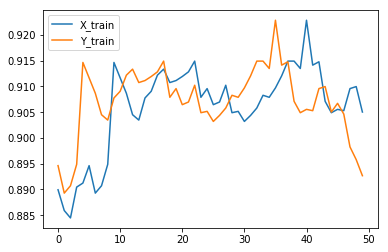

In [92]:
plt.plot(X_train[-50:])
plt.plot(y_train[-50:])
plt.legend(["X_train", "Y_train"])

In [93]:
# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

TypeError: Error converting shape to a TensorShape: int() argument must be a string, a bytes-like object or a number, not 'tuple'.

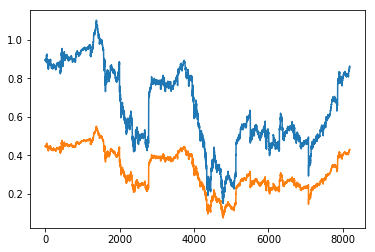

In [77]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

In [78]:
X_test.shape

(8188, 501)

In [79]:
# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

In [80]:
# Run
epochs = 10
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            #line2.set_ydata(pred)
            #plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            #plt.pause(0.01)


MSE Train:  0.3775393
MSE Test:  0.40901873
MSE Train:  0.0011361359
MSE Test:  0.04010399
MSE Train:  0.0008854061
MSE Test:  0.029452903
MSE Train:  0.000733108
MSE Test:  0.022782091
MSE Train:  0.0006304096
MSE Test:  0.019747868
MSE Train:  0.00065969274
MSE Test:  0.016535502
MSE Train:  0.0006952028
MSE Test:  0.022459503
MSE Train:  0.0006114364
MSE Test:  0.020923438
MSE Train:  0.0006259319
MSE Test:  0.01167648
MSE Train:  0.00065026776
MSE Test:  0.009180828
MSE Train:  0.000496312
MSE Test:  0.0077720983
MSE Train:  0.0011834307
MSE Test:  0.011028275
MSE Train:  0.0006811373
MSE Test:  0.0057936194
MSE Train:  0.0006155386
MSE Test:  0.0065279924
MSE Train:  0.0004665493
MSE Test:  0.0050814664
MSE Train:  0.000574499
MSE Test:  0.0061639235
MSE Train:  0.0007360301
MSE Test:  0.006450353
MSE Train:  0.00064675295
MSE Test:  0.0060705226
MSE Train:  0.0007432477
MSE Test:  0.0049153613
MSE Train:  0.0006024697
MSE Test:  0.0046072113
MSE Train:  0.0004845769
MSE Test:  0.

In [81]:
data_last50 = data[np.arange(-50, -1), :]
data_last50

array([[2470.8401,   44.81  ,  163.94  , ...,   76.61  ,  114.6   ,
          62.7   ],
       [2471.26  ,   44.795 ,  163.9456, ...,   76.6   ,  114.62  ,
          62.705 ],
       [2471.3501,   44.8   ,  163.9909, ...,   76.609 ,  114.62  ,
          62.705 ],
       ...,
       [2471.77  ,   44.73  ,  164.12  , ...,   76.9   ,  114.33  ,
          62.71  ],
       [2470.03  ,   44.74  ,  164.01  , ...,   76.88  ,  114.31  ,
          62.685 ],
       [2471.49  ,   44.71  ,  163.88  , ...,   76.83  ,  114.23  ,
          62.6301]])

In [82]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_last50)
data_last50 = scaler.transform(data_last50)

X_last50 = data_last50[:, 0:]
y_last50 = data_last50[:, 0]
X_last50.shape

(49, 501)

In [83]:
pred = net.run(out, feed_dict={X: X_last50})
pred[0]

array([-0.34581578, -0.4369883 , -0.29223078, -0.31251287, -0.26056188,
       -0.2515648 , -0.21907577, -0.10398975, -0.07539711, -0.02147008,
        0.03479286, -0.03109716,  0.02740285,  0.08593597,  0.0810334 ,
        0.21089238,  0.23212983,  0.14370227, -0.01431286,  0.13242523,
        0.1717223 ,  0.17279893,  0.4049496 ,  0.42939332,  0.47088504,
        0.5186318 ,  0.53897655,  0.6808746 ,  0.71294343,  0.72269607,
        0.68807495,  0.7442271 ,  0.78456855,  0.87996966,  0.7950107 ,
        0.36095905,  0.35524347,  0.41914773,  0.16612092,  0.22063844,
       -0.01621434, -0.2418754 ,  0.2040026 ,  0.23591313, -0.02886212,
       -0.12478474,  0.04832104, -0.21854499, -0.84068125], dtype=float32)

In [84]:
X_last50

array([[-0.66730323,  0.69230769, -0.70731707, ..., -0.93548387,
         0.68181818,  0.0363232 ],
       [-0.49485616,  0.46153846, -0.68      , ..., -1.        ,
         0.77272727,  0.11045219],
       [-0.45785334,  0.53846154, -0.45902439, ..., -0.94193548,
         0.77272727,  0.11045219],
       ...,
       [-0.28540627, -0.53846154,  0.17073171, ...,  0.93548387,
        -0.54545455,  0.18458117],
       [-1.        , -0.38461538, -0.36585366, ...,  0.80645161,
        -0.63636364, -0.18606375],
       [-0.40039837, -0.84615385, -1.        , ...,  0.48387097,
        -1.        , -1.        ]])

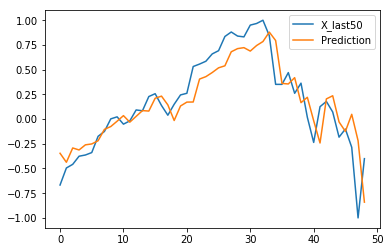

In [85]:
plt.plot(X_last50[:, 0])
plt.plot(pred[0])
plt.legend(["X_last50", "Prediction"])
plt.show()